#  Similar Wines

This notebook will use wine review dataset (https://www.kaggle.com/zynicide/wine-reviews) for finding similarities between several wines.

For this we will use text features present in the dataset (description and variety) as well as value features (review score and price tag).


### 1. Loading the dependencies

For this we will need Pandas to perform a cleaning and transform columns of the dataset, Numpy for NumPy arrays and finally sklearn for building our model.


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df = pd.read_csv('datasets/winemag-data.csv')

# Print the first five to check if the dataframe was correctly loaded
print(df.head())

   row   country                                        description  \
0    0     Italy  Aromas include tropical fruit, broom, brimston...   
1    1  Portugal  This is ripe and fruity, a wine that is smooth...   
2    2        US  Tart and snappy, the flavors of lime flesh and...   
3    3        US  Pineapple rind, lemon pith and orange blossom ...   
4    4        US  Much like the regular bottling from 2012, this...   

                          designation  points  price           province  \
0                        Vulkà Bianco      87    NaN  Sicily & Sardinia   
1                            Avidagos      87   15.0              Douro   
2                                 NaN      87   14.0             Oregon   
3                Reserve Late Harvest      87   13.0           Michigan   
4  Vintner's Reserve Wild Child Block      87   65.0             Oregon   

              region_1           region_2         taster_name  \
0                 Etna                NaN       Kerin O’K



### 2. Remove unwanted columns

Since the purpose of this notebook is to cluster wines by their similarities, we remove columns that are not of our interest

In [37]:
cols_to_remove = ['row', 'region_1', 'region_2', 'taster_name', 'taster_twitter_handle', 'winery', 'designation']

df.drop(cols_to_remove, inplace=True, axis='columns')

# Reorder the dataframe in order to keep the columns of evaluation in the end
df = df.reindex(columns=['title', 'country', 'province', 'points', 'price', 'description', 'variety'])

# Display the shorter dataframe
print(df.head())

                                               title   country  \
0                  Nicosia 2013 Vulkà Bianco  (Etna)     Italy   
1      Quinta dos Avidagos 2011 Avidagos Red (Douro)  Portugal   
2      Rainstorm 2013 Pinot Gris (Willamette Valley)        US   
3  St. Julian 2013 Reserve Late Harvest Riesling ...        US   
4  Sweet Cheeks 2012 Vintner's Reserve Wild Child...        US   

            province  points  price  \
0  Sicily & Sardinia      87    NaN   
1              Douro      87   15.0   
2             Oregon      87   14.0   
3           Michigan      87   13.0   
4             Oregon      87   65.0   

                                         description         variety  
0  Aromas include tropical fruit, broom, brimston...     White Blend  
1  This is ripe and fruity, a wine that is smooth...  Portuguese Red  
2  Tart and snappy, the flavors of lime flesh and...      Pinot Gris  
3  Pineapple rind, lemon pith and orange blossom ...        Riesling  
4  Much like 


### 3. Cleaning and optimizing the dataframe

Now our dataframe is shorter, title will be used for identifying the wines after we implement the model, remaining columns will be used for feature evaluation.

First we need to see if we have null values, and if that's the case, deal with them

In [38]:
print(df.isnull().sum())

title             0
country          63
province         63
points            0
price          8996
description       0
variety           1
dtype: int64


From this sample we can see that there are 63 samples with no region/country, 1 without variety and nearly 9k of null prices.

For the first three, we drop those samples, the numbers are quite small to make a difference

In [39]:
df.dropna(subset=['province', 'country', 'variety'], inplace=True)

# We check again to see how many do we have left with null values
print(df.isnull().sum())

title             0
country           0
province          0
points            0
price          8992
description       0
variety           0
dtype: int64



The price represents around 6%, which makes a reasonable amount of data to just simply throw away, we need to impute a value to price so we can use it properly.

Let's check the range of prices available

In [40]:
print(df['price'].describe())

count    120915.000000
mean         35.368796
std          41.031188
min           4.000000
25%          17.000000
50%          25.000000
75%          42.000000
max        3300.000000
Name: price, dtype: float64



Here we can see that price ranges from 4 to 3300\\$, but the average a price of 35\\$, but wine price tends to varying from country to country, so let's see if this average value matchs the average per country

In [41]:
df_price_per_country = df.groupby('country')['price'].mean()

print(df_price_per_country)

country
Argentina                 24.510117
Armenia                   14.500000
Australia                 35.437663
Austria                   30.762772
Bosnia and Herzegovina    12.500000
Brazil                    23.765957
Bulgaria                  14.645390
Canada                    35.712598
Chile                     20.787316
China                     18.000000
Croatia                   25.450704
Cyprus                    16.272727
Czech Republic            24.250000
Egypt                           NaN
England                   51.681159
France                    41.139120
Georgia                   19.321429
Germany                   42.257547
Greece                    22.364425
Hungary                   40.648276
India                     13.333333
Israel                    31.768916
Italy                     39.663770
Lebanon                   30.685714
Luxembourg                23.333333
Macedonia                 15.583333
Mexico                    26.785714
Moldova             

In [42]:
countries = df['country'].unique()

# For each country we fill null values with its respective price average (calculated above)
for country in df['country'].unique():
    avg_price = df_price_per_country[country]
    
    if np.isnan(avg_price):
        avg_price = 0

    df.loc[(df['country'] == country) & (df['price'].isnull()), 'price'] = avg_price
    
print(df.isnull().sum())

title          0
country        0
province       0
points         0
price          0
description    0
variety        0
dtype: int64



Empty values are now taken care of, now we need to optimize the dataset, since and prepare them for feature extraction, one way is to convert a low variance level of value columns to categories, not only will improve memory but will help when converting to features.

In [43]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129907 entries, 0 to 129970
Data columns (total 7 columns):
title          129907 non-null object
country        129907 non-null object
province       129907 non-null object
points         129907 non-null int64
price          129907 non-null float64
description    129907 non-null object
variety        129907 non-null object
dtypes: float64(1), int64(1), object(5)
memory usage: 7.9+ MB
None


Another aspect that may be optimized is the review score, let's see the value interval for points is betwen 80 and 100, which can be converted to a int8 instead of int64

In [44]:
print(df['points'].describe())

df['points'] = df['points'].astype('int8')

print(df.info())

count    129907.000000
mean         88.447051
std           3.040078
min          80.000000
25%          86.000000
50%          88.000000
75%          91.000000
max         100.000000
Name: points, dtype: float64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 129907 entries, 0 to 129970
Data columns (total 7 columns):
title          129907 non-null object
country        129907 non-null object
province       129907 non-null object
points         129907 non-null int8
price          129907 non-null float64
description    129907 non-null object
variety        129907 non-null object
dtypes: float64(1), int8(1), object(5)
memory usage: 7.1+ MB
None


In [45]:

# Check how many unique values are in all columns
df.nunique()

title          118780
country            43
province          425
points             21
price             412
description    119895
variety           701
dtype: int64

We can clearly categorize countries, province and variety as we have less than a 1000 possible choices for each, and our sample has more than 120k entries

In [46]:
category_columns = ['country','province','variety']

for column in category_columns:
    df[column] = df[column].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129907 entries, 0 to 129970
Data columns (total 7 columns):
title          129907 non-null object
country        129907 non-null category
province       129907 non-null category
points         129907 non-null int8
price          129907 non-null float64
description    129907 non-null object
variety        129907 non-null category
dtypes: category(3), float64(1), int8(1), object(2)
memory usage: 4.8+ MB


We are using less memory now, and our dataset is now cleared for the next step



### 4. Extracting features

We want to use text words present in description, variety, country and province for evaluation in the clustering model, we achieve this by using CountVectorizer.

Imagine we have 2 samples with the following information

| Sample | Text |
|------|------|
| Joe | One dog and a cat |
| Jane | Five fishes and a cat |

Our vectorizer will perform a tokeneziation, count the occurances and remove single characters that provide linkage, resulting in something like this

| Sample | one | dog | and | cat | five | fishes |
|------|------|------|------|------|------|------|
| Joe | 1 | 1 | 1 | 1 | 0 | 0 |
| Jane | 0 | 0 | 1 | 1 | 1 | 1 |





We need to address in our bag of words, the first is to retain only words that are present in in more than a few documents (like 0.5% of our sample).

The other is to remove stop words, these are some of the words(the, that, it, etc) these do not provide any value, we will use Scikit's english stop words

In [47]:
columns_to_merge = ['description', 'variety' ]

# We need to merge the columns with the strings we want to evaluate into just one
features_df = df
features_df['text'] = features_df[columns_to_merge].apply(lambda x: ' '.join(x), axis=1)
features_df.drop(columns_to_merge, axis=1, inplace=True)

vectorizer = CountVectorizer(min_df=0.005, stop_words='english')

matrix = vectorizer.fit_transform(features_df['text'].values)

text_features = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names())

# We need to reset the index in order to avoid mismatch in columns concatenating
features_df.reset_index(drop=True, inplace=True)
text_features.reset_index(drop=True, inplace=True)

vectorized_df = pd.concat([features_df, text_features], axis=1)

vectorized_df.drop('text', axis=1, inplace=True)

print(vectorized_df.shape)

del features_df


(129907, 762)




### 5. Scaling the values

Now that our dataframe as the features extracted, we need to scale our dataset, more accurately, we want to normalize our values so that the stay around 0.

This feature allows us to avoid the model to consider one feature over the other if the range of values if quite different.

Imagine a feature for a word (example: fruity) which can happen per sample, one or 2 times, now it's price may be somewhat 30, and it's review with score of 80. 
Which makes the review or price the most relevant features. In this specific case, it's not desired.


In [48]:
scaler = StandardScaler()

# We get all columns except title, country and region (which serve for labeling purposes)
features = vectorized_df.iloc[:, 3:-1]

new_features = scaler.fit_transform(features.values)



### 6 Dimensional Reduction

Now that our values are more standardized, we can see that we have a great number of features (Columns of our feature array).

This number makes hard for visualization our the correlation between groups and harder for clustering. We'll use PCA for dimensional reduction

In [49]:
pca = PCA(n_components=2)

reduced_featured = pca.fit_transform(new_features)

print(reduced_featured.shape)

# Join the dataframe with the labels
reduced_features_df = pd.DataFrame(reduced_featured, columns=['PCA1', 'PCA2'])

wine_df = pd.concat([vectorized_df[['title', 'country', 'province']], reduced_features_df], axis=1)

print(wine_df.shape)

del reduced_features_df

(129907, 2)
(129907, 5)



Let's try to visualize a sample of those wines using a scatter plot. we'll choose a subset of Portuguese wines for testing purposes.

                                                 title   country    province  \
1        Quinta dos Avidagos 2011 Avidagos Red (Douro)  Portugal       Douro   
79   Adega Cooperativa do Cartaxo 2014 Bridão Touri...  Portugal        Tejo   
151  Herdade Grande 2014 Gerações Colheita Seleccio...  Portugal  Alentejano   
157  Casa Santa Vitória 2013 Grande Reserva Tinto R...  Portugal  Alentejano   
203  Adega Cooperativa de Borba 2012 Montes Claros ...  Portugal    Alentejo   

         PCA1      PCA2  
1   -0.078356  4.162268  
79  -0.071325  1.773074  
151 -2.376528  6.613706  
157  1.296656  5.685530  
203 -0.467359  4.779450  


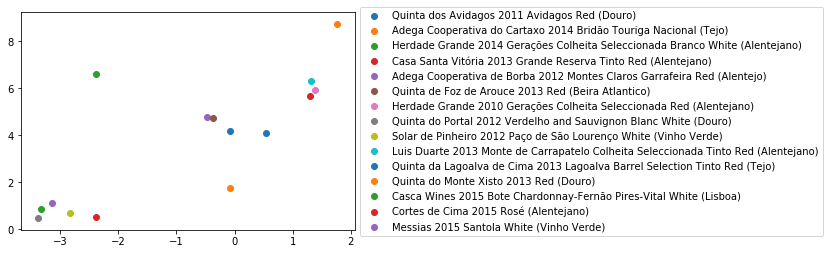

In [50]:
%matplotlib inline

sample_df = wine_df[wine_df['country'] == "Portugal"].head(15)
#sample_df.sort_values(['PCA1', 'PCA2'])

print(sample_df.head(5))

fig, ax = plt.subplots()

labels = sample_df['title'].values
x = sample_df['PCA1'].values
y = sample_df['PCA2'].values

index = 0
legend = []
for label in labels:
    plt.scatter(x[index], y[index], label=label)
    index += 1
    
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


Looking at the plot above there are a few things that come out, first is that it seems to have separated more the red wines from rosé and whites (since the taste of red and white wines are different), this largely is due to the factors taken into account by reviews.



### 7 Clustering

Now we begin by clustering our data, this section will focus on training our clustering models and evaluating how good it performs and finally, test it with some data.

We will use K-Means for clutering, this unsupervised model is quite popular and easy to use, but it has a downside, the number of clusters mas be specified at the beginning.

Since we don't know the ideal number, we will have to run several iterations to find an ideal one.

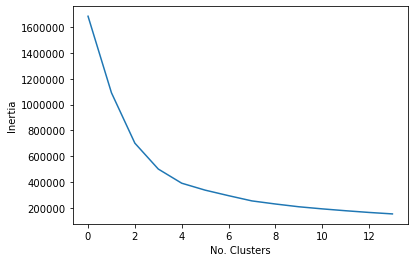

In [51]:
iteration_inertias = []

features = wine_df.values[:,3:]

clusters = range(1,15)

for cluster in clusters:
    kmeans = KMeans(n_clusters=cluster)
    
    kmeans.fit(features)
    
    iteration_inertias.append(kmeans.inertia_)

_ = plt.plot(iteration_inertias)
_ = plt.xlabel("No. Clusters")
_ = plt.ylabel("Inertia")

As we can see, the curve begins to descend more slowly at 4 clusters, which is our optimal number